<a href="https://colab.research.google.com/github/whatalnk/Gasyori100knockColab/blob/master/notebooks/Question_01_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls

sample_data


In [2]:
!wget https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/Question_01_10/imori.jpg

--2019-11-10 05:01:51--  https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/Question_01_10/imori.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12638 (12K) [image/jpeg]
Saving to: ‘imori.jpg’

imori.jpg           100%[===================>]  12.34K  --.-KB/s    in 0s      

2019-11-10 05:01:51 (164 MB/s) - ‘imori.jpg’ saved [12638/12638]



In [0]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

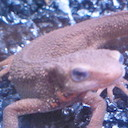

In [4]:
img = cv2.imread("imori.jpg")

cv2_imshow(img)

## Q1 B と R を入れ替え

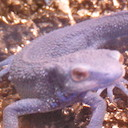

In [0]:
img_ = img[:, :, (2, 1, 0)].copy()
cv2_imshow(img_)

## Q2 グレースケール

Y = 0.2126 R + 0.7152 G + 0.0722 B

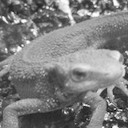

In [0]:
def BGR2GRAY(img):
  R = img[:, :, 2].copy()
  G = img[:, :, 1].copy()
  B = img[:, :, 0].copy()
  ret = (0.2126 * R + 0.7152 * G + 0.0722 * B).astype(np.uint8)
  return(ret)
img_gray = BGR2GRAY(img)
cv2_imshow(img_gray)

## Q3 二値化

閾値 128 

```
y = { 0 (if y < 128)
     255 (else) 
```

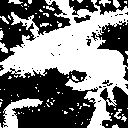

In [0]:
def binarize(img, thr = 128):
  ret = img.copy()
  ret[ret < thr] = 0
  ret[ret >= thr] = 255
  return(ret)
BW = binarize(img_gray, 128)
cv2_imshow(BW)

## Q4 大津の二値化

* 閾値 $t$ 未満を クラス1，以上を クラス2
* クラス1 画素数割合を $w_1$，クラス2 を $w_2$ とする
  * $w_1 + w_2 = 1$
* 各クラスの画素値の分散をそれぞれ $S_1^2$ ， $S_2^2$
* 全体，各クラスの画素値の平均値をそれぞれ $M_0$， $M_1$ ， $M_2$

クラス内分散 $S_w$ は，

$$ S_w^2 = w_1 S_1^2 + w_2 S_2^2 $$

クラス間分散 $S_b$ は，

\begin{eqnarray}
S_b^2 &=& w_1 (M_1 - M_0)^2 + w_2(M_2 - M_0)^2 \\
    &=& w_1 (M_1^2 - 2M_1 M_0 + M_0^2) + w_2(M_2^2 - 2 M_2 M_0 + M_0^2) \\
    &=& w_1 M_1^2 + w_2 M_2^2 - 2M_0(w_1 M_1 + w_2 M_2) + M_0^2 (w_1 + w_2) \\
    &=& w_1 M_1^2 + w_2 M_2^2 -(w_1 M_1 + w_2 M_2)^2 \\
    &=& ... \\
    &=& w_1 w_2 (M_1 - M_2)^2
\end{eqnarray}

画像全体の画素の分散は，

$$ S_0^2 = S_w^2 + S_b^2 = const $$

分離度は，

$$ X = \frac{S_b^2}{S_w^2} = \frac{S_b^2}{S_0^2 - S_b^2} $$

なので，

$$ \text{argmax}X = \text{argmax}S_b^2 $$

Threshold:  127


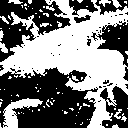

In [0]:
def otsu_binarization(img):
  thr = 0
  Sb_max = 0
  H, W = img.shape
  for t in range(0, 256):
    c1 = img[np.where(img < t)]
    w1 = len(c1) / (H * W)
    c2 = img[np.where(img >= t)]
    w2 = len(c2) / (H * W)
    M1 = np.mean(c1) if len(c1 > 0) else 0.
    M2 = np.mean(c2) if len(c2 > 0) else 0.
    Sb = w1 * w2 * (M1 - M2)**2
    if Sb > Sb_max:
      thr = t
      Sb_max = Sb
  print("Threshold: ", thr)
  ret = binarize(img, thr)
  return ret
out = otsu_binarization(img_gray)
cv2_imshow(out)

## Q.5. HSV変換

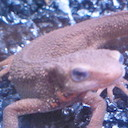

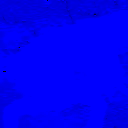

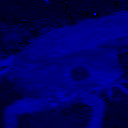

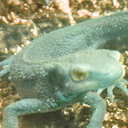

In [0]:
def BGR2HSV(img):
  def BGR2HSV_(pix):
    B, G, R = pix / 255.
    Max = max(B, G, R)
    Min = min(B, G, R)
    V = Max
    S = Max - Min
    if Min == Max:
      H = 0
    elif Min == B:
      H = (60 * (G - R) / S + 60)
    elif Min == R:
      H = (60 * (B - G) / S + 180)
    elif Min == G:
      H = (60 * (R - B) / S + 300)
    return [H, S, V]
  ret = np.array([[BGR2HSV_(y) for y in x] for x in img])
  return ret

def HSV2BGR(img):
  img_ = img.copy()
  out = np.zeros_like(img, dtype=np.float32)

  H = img[..., 0].copy()
  S = img[..., 1].copy()
  V = img[..., 2].copy()
  
  C = S
  H_ = H / 60.
  X = C * (1 - np.abs((H_ % 2) - 1))
  Z = np.zeros_like(H_, dtype=np.float32)

  vals = [[Z, X, C], [Z, C, X], [X, C, Z], [C, X, Z], [C, Z, X], [X, Z, C]]

  for i in range(6):
    ind = np.where((i <= H_) & (H_ < (i+1)))
    out[..., 0][ind] = (V - C)[ind] + vals[i][0][ind] 
    out[..., 1][ind] = (V - C)[ind] + vals[i][1][ind]
    out[..., 2][ind] = (V - C)[ind] + vals[i][2][ind]
  out = np.clip(out, 0, 1)
  out = (out * 255).astype(np.uint8)
  return(out)

# original
img = cv2.imread("imori.jpg")
cv2_imshow(img)
print()

# BGR => HSV
img_hsv = BGR2HSV(img)
cv2_imshow(img_hsv)
print()

# H を反転
img_hsv[..., 0] = (img_hsv[..., 0] + 180) % 360
cv2_imshow(img_hsv)
print()

# HSV => BGR
img_hsv_bgr = HSV2BGR(img_hsv)
cv2_imshow(img_hsv_bgr)

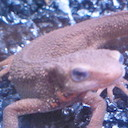

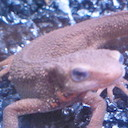

In [0]:
cv2_imshow(img)
print()

out = BGR2HSV(img)
out = HSV2BGR(out)
cv2_imshow(out)

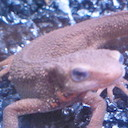

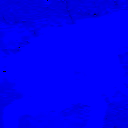

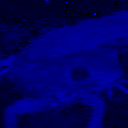

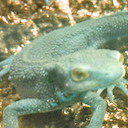

In [0]:
def BGR2HSV(img):
  img_ = img.copy() / 255.
  out = np.zeros_like(img_, dtype=np.float32)

  max_v = np.max(img_, axis=2).copy()
  min_v = np.min(img_, axis=2).copy()
  min_arg = np.argmin(img_, axis=2)

  # H
  out[..., 0][np.where(max_v == min_v)] = 0
  # Min == B; H = (60 * (G - R) / (Max - Min) + 60)
  ind = np.where(min_arg == 0)
  out[..., 0][ind] = 60 * (img_[..., 1][ind] - img_[..., 2][ind]) / (max_v[ind] - min_v[ind]) + 60
  
  # Min == R; H = (60 * (B - G) / (Max - Min) + 180)
  ind = np.where(min_arg == 2)
  out[..., 0][ind] = 60 * (img_[..., 0][ind] - img_[..., 1][ind]) / (max_v[ind] - min_v[ind]) + 180
  
  # Min == G; H = (60 * (R - B) / (Max - Min) + 300)
  ind = np.where(min_arg == 1)
  out[..., 0][ind] = 60 * (img_[..., 2][ind] - img_[..., 0][ind]) / (max_v[ind] - min_v[ind]) + 300

  # S
  out[..., 1] = max_v.copy() - min_v.copy()

  # V
  out[..., 2] = max_v.copy()

  return out

def HSV2BGR(_img, hsv):
	img = _img.copy() / 255.

	# get max and min
	max_v = np.max(img, axis=2).copy()
	min_v = np.min(img, axis=2).copy()

	out = np.zeros_like(img)

	H = hsv[..., 0]
	S = hsv[..., 1]
	V = hsv[..., 2]

	C = S
	H_ = H / 60.
	X = C * (1 - np.abs( H_ % 2 - 1))
	Z = np.zeros_like(H)

	vals = [[Z,X,C], [Z,C,X], [X,C,Z], [C,X,Z], [C,Z,X], [X,Z,C]]

	for i in range(6):
		ind = np.where((i <= H_) & (H_ < (i+1)))
		out[..., 0][ind] = (V - C)[ind] + vals[i][0][ind]
		out[..., 1][ind] = (V - C)[ind] + vals[i][1][ind]
		out[..., 2][ind] = (V - C)[ind] + vals[i][2][ind]

	out[np.where(max_v == min_v)] = 0
	out = np.clip(out, 0, 1)
	out = (out * 255).astype(np.uint8)

	return out


img = cv2.imread("imori.jpg").astype(np.float32)
cv2_imshow(img)
print()

# BGR => HSV
img_hsv = BGR2HSV(img)
cv2_imshow(img_hsv)
print()

# H を反転
img_hsv[..., 0] = (img_hsv[..., 0] + 180) % 360
cv2_imshow(img_hsv)
print()

# HSV => BGR
img_hsv_bgr = HSV2BGR(img, img_hsv)
cv2_imshow(img_hsv_bgr)

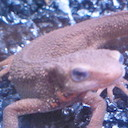

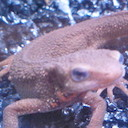

In [0]:
cv2_imshow(img)
print()

out = BGR2HSV(img)
out = HSV2BGR(img, out)
cv2_imshow(out)

## Q6 減色処理

```
val = {  32  (  0 <= val <  64)
         96  ( 64 <= val < 128)
        160  (128 <= val < 192)
        224  (192 <= val < 256)
```

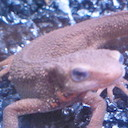

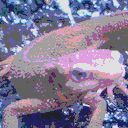

In [0]:
def color_reduction(img):
  B = img[..., 0].copy()
  G = img[..., 1].copy()
  R = img[..., 2].copy()
  out = np.zeros_like(img, dtype=np.uint8)

  thr = [0, 64, 128, 192, 256]
  vals = [32, 96, 160, 224]
  for i in range(4):
    ind = np.where((B >= thr[i]) & (B < thr[i+1]))
    out[..., 0][ind] = vals[i]
    ind = np.where((G >= thr[i]) & (G < thr[i+1]))
    out[..., 1][ind] = vals[i]
    ind = np.where((R >= thr[i]) & (R < thr[i+1]))
    out[..., 2][ind] = vals[i]
  return out

img = cv2.imread("imori.jpg")
cv2_imshow(img)
print()
out = color_reduction(img)
cv2_imshow(out)

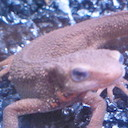

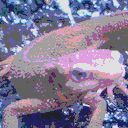

In [0]:
def dicrease_color(img):
	out = img.copy()

	out = out // 64 * 64 + 32

	return out

img = cv2.imread("imori.jpg")
cv2_imshow(img)
print()
out = dicrease_color(img)
cv2_imshow(out)

## Q7 平均プーリング

8 $\times$ 8 に分ける



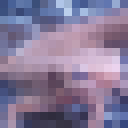

In [0]:
def average_pooling(img):
  img_ = img.copy()
  for i in range(16):
    for j in range(16):
      for k in range(3):
        img_[..., k][(i*8):((i+1)*8), (j*8):((j+1)*8)] = np.mean(img_[..., k][(i*8):((i+1)*8), (j*8):((j+1)*8)])
  return img_

out = average_pooling(img)
cv2_imshow(out)

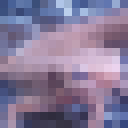

In [0]:
def average_pooling(img, G=8):
    out = img.copy()

    H, W, C = img.shape
    Nh = int(H / G)
    Nw = int(W / G)

    for y in range(Nh):
        for x in range(Nw):
            for c in range(C):
                out[G*y:G*(y+1), G*x:G*(x+1), c] = np.mean(out[G*y:G*(y+1), G*x:G*(x+1), c]).astype(np.int)
    
    return out
    
out = average_pooling(img)
cv2_imshow(out)

## Q8 Max プーリング 

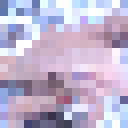

In [9]:
def max_pooling(img, n=8):
  out = img.copy()
  H, W, C = out.shape
  
  nh = H // n
  nw = W // n

  for h in range(nh):
    for w in range(nw):
      for c in range(C):
        out[(h * n):((h + 1) * n), (w * n):((w + 1) * n), c] = np.max(out[(h * n):((h + 1) * n), (w * n):((w + 1) * n), c]).astype(np.int)
  return out
out = max_pooling(img, 8)
cv2_imshow(out)